In [29]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression,LinearRegression,SGDRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score,classification_report, confusion_matrix, mean_absolute_error, mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor,AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR,LinearSVR,NuSVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, GRU, LSTM, RepeatVector, TimeDistributed,Conv1D,MaxPooling1D,ReLU,UpSampling1D,Input,LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from keras.layers.core import Dense
from keras.layers.merge import concatenate
from tensorflow.keras.layers import Average
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
import pywt
from scipy.fft import fft,ifft
from sklearn.preprocessing import OneHotEncoder

In [30]:
data = pd.read_csv('train_FD001.txt', sep = ' ', header = None)
data.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
           dtype='int64')

In [31]:
data_act = data[[f for f in range(0, 26)]]
data_act.columns = ["ID", "Cycle", "OpSet1", "OpSet2", "OpSet3", "SensorMeasure1", "SensorMeasure2", "SensorMeasure3", "SensorMeasure4",
                "SensorMeasure5", "SensorMeasure6", "SensorMeasure7", "SensorMeasure8", "SensorMeasure9", "SensorMeasure10", "SensorMeasure11",
                "SensorMeasure12", "SensorMeasure13", "SensorMeasure14", "SensorMeasure15", "SensorMeasure16",
                "SensorMeasure17", "SensorMeasure18", "SensorMeasure19", "SensorMeasure20", "SensorMeasure21"]
len(np.unique(data_act['OpSet2']))

13

In [32]:
max_cycles_df = data_act.groupby(["ID"], sort=False)["Cycle"].max().reset_index().rename(columns={"Cycle" : "MaxCycleID"})
max_cycles_df.head()

,ID,MaxCycleID
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


In [33]:
FD001_df = pd.merge(data_act, max_cycles_df, how="inner", on="ID")
FD001_df["RUL"] = FD001_df["MaxCycleID"] - FD001_df["Cycle"]
FD001_df.head()

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,MaxCycleID,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


In [34]:
df_FD001 = FD001_df.copy().drop(columns=["ID", "Cycle", "OpSet1","OpSet2","OpSet3", "MaxCycleID", "RUL"], axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
# print(df_FD001)
scaled_df_FD001 = pd.DataFrame(scaler.fit_transform(df_FD001.values))
scaled_df_FD001 = FD001_df[["ID", "Cycle", "RUL", "OpSet1","OpSet2","OpSet3"]].join(scaled_df_FD001)
scaled_df_FD001.columns = ["ID", "Cycle","RUL","OpSet1","OpSet2", "OpSet3","SensorMeasure1", "SensorMeasure2", "SensorMeasure3", "SensorMeasure4",
                "SensorMeasure5", "SensorMeasure6", "SensorMeasure7", "SensorMeasure8", "SensorMeasure9", "SensorMeasure10", "SensorMeasure11",
                "SensorMeasure12", "SensorMeasure13", "SensorMeasure14", "SensorMeasure15", "SensorMeasure16",
                "SensorMeasure17", "SensorMeasure18", "SensorMeasure19", "SensorMeasure20", "SensorMeasure21"]
print(scaled_df_FD001['OpSet2'].value_counts().idxmax())
print(scaled_df_FD001['OpSet1'].value_counts().idxmax())

-0.0003
0.0


In [35]:
enc_opset1 = OneHotEncoder()
enc_opset2 = OneHotEncoder()
opset1_enc = enc_opset1.fit_transform(scaled_df_FD001['OpSet1'].values.reshape(-1,1)).toarray()
print(opset1_enc.shape)
opset2_enc = enc_opset2.fit_transform(scaled_df_FD001['OpSet2'].values.reshape(-1,1)).toarray()
print(opset2_enc.shape)
print(type(opset1_enc))
print(type(opset2_enc))

(20631, 158)
(20631, 13)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [36]:
scaled_clean_df_FD001 = scaled_df_FD001.drop(columns=["SensorMeasure1", "SensorMeasure5", "SensorMeasure6", "SensorMeasure10",
                                         "SensorMeasure16", "SensorMeasure18", "SensorMeasure19"])
scaled_clean_df_FD001.columns

Index(['ID', 'Cycle', 'RUL', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure2',
       'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure7', 'SensorMeasure8',
       'SensorMeasure9', 'SensorMeasure11', 'SensorMeasure12',
       'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15',
       'SensorMeasure17', 'SensorMeasure20', 'SensorMeasure21'],
      dtype='object')

In [37]:
num_col = ['SensorMeasure2',
       'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure7', 'SensorMeasure8',
       'SensorMeasure9', 'SensorMeasure11', 'SensorMeasure12',
       'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15',
       'SensorMeasure17', 'SensorMeasure20', 'SensorMeasure21']

In [38]:
X_num_tr = scaled_clean_df_FD001[num_col].values
print(X_num_tr.shape)
print(type(X_num_tr))
X_tr = np.concatenate([X_num_tr,opset1_enc,opset2_enc], axis = 1)
print(X_tr.shape)
y_tr = scaled_clean_df_FD001['RUL'].values
print(y_tr.shape)

(20631, 14)
<class 'numpy.ndarray'>
(20631, 185)
(20631,)


93


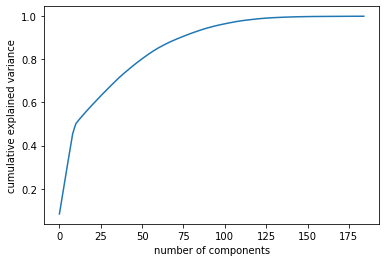

In [39]:
pca = PCA()
pca.fit(X_tr)
var_comp = np.cumsum(pca.explained_variance_ratio_).tolist()
# print(var_comp)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
for i in range(len(var_comp)):
    if var_comp[i] > 0.95:
        print(i+1)
        break

In [40]:
pca = PCA(n_components=93)
X_tr_pc = pca.fit_transform(X_tr)

In [41]:
test_data_FD001 = pd.read_csv('test_FD001.txt', sep = ' ', header = None)
test_data_FD001 = test_data_FD001[[f for f in range(0, 26)]]
test_data_FD001.columns = ["ID", "Cycle", "OpSet1", "OpSet2", "OpSet3", "SensorMeasure1", "SensorMeasure2", "SensorMeasure3", "SensorMeasure4",
                "SensorMeasure5", "SensorMeasure6", "SensorMeasure7", "SensorMeasure8", "SensorMeasure9", "SensorMeasure10", "SensorMeasure11",
                "SensorMeasure12", "SensorMeasure13", "SensorMeasure14", "SensorMeasure15", "SensorMeasure16",
                "SensorMeasure17", "SensorMeasure18", "SensorMeasure19", "SensorMeasure20", "SensorMeasure21"]
test_data_FD001.head()

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [42]:
max_cycles_df_test = test_data_FD001.groupby(["ID"], sort=False)["Cycle"].max().reset_index().rename(columns={"Cycle" : "MaxCycleID"})
max_cycles_df_test.head()

,ID,MaxCycleID
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [43]:
y_test_rul_FD001 = pd.read_csv('RUL_FD001.txt', header = None)
y_test_rul_FD001.columns = ['Eng_rul']
y_test_rul_FD001['ID'] = max_cycles_df_test['ID']
y_test_rul_FD001.head()

,Eng_rul,ID
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [44]:
max_cycles_df_test['MaxCycleIDAct'] = y_test_rul_FD001['Eng_rul']+ max_cycles_df_test['MaxCycleID']
max_cycles_df_test.head()

,ID,MaxCycleID,MaxCycleIDAct
0,1,31,143
1,2,49,147
2,3,126,195
3,4,106,188
4,5,98,189


In [45]:
test_df_FD001 = pd.merge(test_data_FD001, max_cycles_df_test, how="inner", on="ID")
test_df_FD001.head()

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,MaxCycleID,MaxCycleIDAct
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,31,143
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,31,143
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,31,143
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,31,143
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,31,143


In [46]:
test_df_FD001["RUL"] = test_df_FD001["MaxCycleIDAct"] - test_df_FD001["Cycle"]
test_df_FD001.head()

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,MaxCycleID,MaxCycleIDAct,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,31,143,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,31,143,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,31,143,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,31,143,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,31,143,138


In [47]:
te_df_FD001 = test_df_FD001.copy().drop(columns=["ID", "Cycle", "OpSet1", "OpSet2","OpSet3", "MaxCycleID", "MaxCycleIDAct","RUL"], axis=1)
# print(te_df_FD001)
scaled_te_df_FD001 = pd.DataFrame(scaler.transform(te_df_FD001.values))
scaled_te_df_FD001 = test_df_FD001[["ID", "Cycle", "RUL","OpSet1","OpSet2","OpSet3"]].join(scaled_te_df_FD001)
scaled_te_df_FD001.columns = ["ID", "Cycle","RUL", "OpSet1", "OpSet2", "OpSet3","SensorMeasure1", "SensorMeasure2", "SensorMeasure3", "SensorMeasure4",
                "SensorMeasure5", "SensorMeasure6", "SensorMeasure7", "SensorMeasure8", "SensorMeasure9", "SensorMeasure10", "SensorMeasure11",
                "SensorMeasure12", "SensorMeasure13", "SensorMeasure14", "SensorMeasure15", "SensorMeasure16",
                "SensorMeasure17", "SensorMeasure18", "SensorMeasure19", "SensorMeasure20", "SensorMeasure21"]
scaled_te_df_FD001.head()

,ID,Cycle,RUL,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,142,0.0023,0.0003,100.0,0.0,0.545181,0.310661,0.269413,...,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,1,2,141,-0.0027,-0.0003,100.0,0.0,0.150602,0.379551,0.222316,...,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,1,3,140,0.0003,0.0001,100.0,0.0,0.376506,0.346632,0.322248,...,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348
3,1,4,139,0.0042,0.0000,100.0,0.0,0.370482,0.285154,0.408001,...,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110
4,1,5,138,0.0014,0.0000,100.0,0.0,0.391566,0.352082,0.332039,...,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377


In [48]:
unknown_opset1 = [-0.0082, -0.0079, -0.0077, -0.0071, 0.0075, 0.0078]
unknown_opset2 = [0.0007]
for i in range(13096):
    if scaled_te_df_FD001['OpSet1'].iloc[i] in unknown_opset1:
        scaled_te_df_FD001['OpSet1'].iloc[i] = 0.0000
    if scaled_te_df_FD001['OpSet2'].iloc[i] in unknown_opset2:
        scaled_te_df_FD001['OpSet2'].iloc[i] = -0.0003

/Users/shivam.bhardwaj/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [49]:
opset1_enc_te = enc_opset1.transform(scaled_te_df_FD001['OpSet1'].values.reshape(-1,1)).toarray()
opset2_enc_te = enc_opset2.transform(scaled_te_df_FD001['OpSet2'].values.reshape(-1,1)).toarray()

In [50]:
X_te_num = scaled_te_df_FD001[num_col].values
X_te = np.concatenate([X_te_num, opset1_enc_te, opset2_enc_te], axis = 1)
X_te_pc = pca.transform(X_te)
y_te = scaled_te_df_FD001['RUL'].values

In [51]:
y_te.shape

(13096,)

In [52]:
def get_seq(in_arr,out_arr,lb):
    x,y = [],[]
    for i in range(in_arr.shape[0]):
        if (i+lb) <= in_arr.shape[0]:
            x.append(in_arr[i:(i+lb),:])
            y.append(out_arr[(i+lb)-1])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [53]:
x_train,y_train = get_seq(X_tr_pc,y_tr,128) 
x_test,y_test = get_seq(X_te_pc,y_te,128)
print(x_train.shape,y_train.shape)
print(x_test.shape, y_test.shape)

(20504, 128, 93) (20504,)
(12969, 128, 93) (12969,)


In [54]:
def rul_mdl1(batch_size = None,in_feature = x_train.shape[2], out_f = 1, len_ts = x_train.shape[1]):
    inp = layers.Input(batch_shape= (batch_size, len_ts, x_train.shape[2]), name="Input")
    l1 = layers.LSTM(units = int(x_train.shape[2]/2),return_sequences = True, name = 'Bi-LSTM-1')(inp)
    l1d = layers.Dropout(0.3, name = 'DropOut-1')(l1)
    l2 = layers.LSTM(units = int(x_train.shape[2]/4),return_sequences = True, name = 'Bi-LSTM-2')(l1d)
    l2d = layers.Dropout(0.3, name = 'DropOut-2')(l2)
    l3 = layers.LSTM(units = int(x_train.shape[2]/8),return_sequences = False, name = 'Bi-LSTM-3')(l2d)
    l3d = layers.Dropout(0.3, name = 'Dropout-3')(l3)
    l4 = layers.Dense(units = int(x_train.shape[2]/10), activation = 'relu', name = 'Fully-Connected')(l3d)
    l4d = layers.Dropout(0.3, name = 'Dropout-4')(l4)
    out = layers.Dense(units = out_f, activation = 'linear', name = 'Output')(l4d)
    M = models.Model(inputs = inp, outputs =  out)
    M.compile(loss='mean_squared_error', optimizer='adam')
    return M
Model1 = rul_mdl1()
Model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 93)]         0         
_________________________________________________________________
Bi-LSTM-1 (LSTM)             (None, 128, 46)           25760     
_________________________________________________________________
DropOut-1 (Dropout)          (None, 128, 46)           0         
_________________________________________________________________
Bi-LSTM-2 (LSTM)             (None, 128, 23)           6440      
_________________________________________________________________
DropOut-2 (Dropout)          (None, 128, 23)           0         
_________________________________________________________________
Bi-LSTM-3 (LSTM)             (None, 11)                1540      
_________________________________________________________________
Dropout-3 (Dropout)          (None, 11)                0   

Epoch 1/1000
4/4 [==============================] - 45s 9s/step - loss: 15301.6836 - val_loss: 19465.2734
Epoch 2/1000
4/4 [==============================] - 42s 11s/step - loss: 15277.7441 - val_loss: 19422.4004
Epoch 3/1000
4/4 [==============================] - 23s 6s/step - loss: 15236.1504 - val_loss: 19352.5625
Epoch 4/1000
4/4 [==============================] - 21s 5s/step - loss: 15171.1357 - val_loss: 19254.7793
Epoch 5/1000
4/4 [==============================] - 15s 4s/step - loss: 15070.4756 - val_loss: 19142.5566
Epoch 6/1000
4/4 [==============================] - 15s 4s/step - loss: 14990.3105 - val_loss: 19097.6426
Epoch 7/1000
4/4 [==============================] - 13s 3s/step - loss: 14947.4561 - val_loss: 19054.1953
Epoch 8/1000
4/4 [==============================] - 16s 4s/step - loss: 14907.7695 - val_loss: 19009.4395
Epoch 9/1000
4/4 [==============================] - 15s 3s/step - loss: 14866.5215 - val_loss: 18962.5977
Epoch 10/1000
4/4 [==========================

4/4 [==============================] - 22s 5s/step - loss: 11263.7637 - val_loss: 14812.2998
Epoch 78/1000
4/4 [==============================] - 15s 4s/step - loss: 11198.1768 - val_loss: 14737.5996
Epoch 79/1000
4/4 [==============================] - 16s 4s/step - loss: 11160.8271 - val_loss: 14662.7295
Epoch 80/1000
4/4 [==============================] - 21s 5s/step - loss: 11122.4434 - val_loss: 14587.8252
Epoch 81/1000
4/4 [==============================] - 16s 4s/step - loss: 11012.3174 - val_loss: 14512.7178
Epoch 82/1000
4/4 [==============================] - 20s 6s/step - loss: 10958.6973 - val_loss: 14437.3613
Epoch 83/1000
4/4 [==============================] - 21s 5s/step - loss: 10920.0664 - val_loss: 14361.8262
Epoch 84/1000
4/4 [==============================] - 15s 4s/step - loss: 10839.1309 - val_loss: 14286.1992
Epoch 85/1000
4/4 [==============================] - 19s 5s/step - loss: 10775.8867 - val_loss: 14210.6143
Epoch 86/1000
4/4 [==============================] 

Epoch 154/1000
4/4 [==============================] - 19s 5s/step - loss: 7095.2676 - val_loss: 9454.4473
Epoch 155/1000
4/4 [==============================] - 19s 4s/step - loss: 7055.7603 - val_loss: 9400.4287
Epoch 156/1000
4/4 [==============================] - 15s 4s/step - loss: 7075.1318 - val_loss: 9346.9609
Epoch 157/1000
4/4 [==============================] - 25s 6s/step - loss: 6979.6719 - val_loss: 9294.1641
Epoch 158/1000
4/4 [==============================] - 19s 4s/step - loss: 6935.2109 - val_loss: 9241.8389
Epoch 159/1000
4/4 [==============================] - 18s 4s/step - loss: 6915.2773 - val_loss: 9189.9277
Epoch 160/1000
4/4 [==============================] - 15s 4s/step - loss: 6895.4102 - val_loss: 9138.6641
Epoch 161/1000
4/4 [==============================] - 19s 5s/step - loss: 6845.3252 - val_loss: 9088.0801
Epoch 162/1000
4/4 [==============================] - 20s 5s/step - loss: 6814.6406 - val_loss: 9038.1084
Epoch 163/1000
4/4 [==========================

4/4 [==============================] - 16s 4s/step - loss: 5656.4805 - val_loss: 6934.9507
Epoch 232/1000
4/4 [==============================] - 25s 7s/step - loss: 5712.5498 - val_loss: 6920.4648
Epoch 233/1000
4/4 [==============================] - 16s 4s/step - loss: 5665.1875 - val_loss: 6906.1318
Epoch 234/1000
4/4 [==============================] - 22s 5s/step - loss: 5672.7974 - val_loss: 6892.0576
Epoch 235/1000
4/4 [==============================] - 15s 4s/step - loss: 5696.9868 - val_loss: 6878.3394
Epoch 236/1000
4/4 [==============================] - 14s 4s/step - loss: 5668.9810 - val_loss: 6865.0107
Epoch 237/1000
4/4 [==============================] - 21s 6s/step - loss: 5624.3579 - val_loss: 6851.9502
Epoch 238/1000
4/4 [==============================] - 18s 4s/step - loss: 5656.1489 - val_loss: 6838.9019
Epoch 239/1000
4/4 [==============================] - 15s 4s/step - loss: 5631.2036 - val_loss: 6826.2012
Epoch 240/1000
4/4 [==============================] - 20s 5s/

4/4 [==============================] - 21s 5s/step - loss: 5612.4341 - val_loss: 6410.6279
Epoch 309/1000
4/4 [==============================] - 36s 9s/step - loss: 5583.2417 - val_loss: 6408.9287
Epoch 310/1000
4/4 [==============================] - 25s 6s/step - loss: 5555.3345 - val_loss: 6407.2852
Epoch 311/1000
4/4 [==============================] - 25s 6s/step - loss: 5633.7524 - val_loss: 6405.4971
Epoch 312/1000
4/4 [==============================] - 15s 4s/step - loss: 5555.3779 - val_loss: 6403.8213
Epoch 313/1000
4/4 [==============================] - 15s 4s/step - loss: 5574.7344 - val_loss: 6402.0972
Epoch 314/1000
4/4 [==============================] - 19s 5s/step - loss: 5591.7407 - val_loss: 6400.7856
Epoch 315/1000
4/4 [==============================] - 19s 4s/step - loss: 5549.5405 - val_loss: 6399.2432
Epoch 316/1000
4/4 [==============================] - 24s 5s/step - loss: 5597.6997 - val_loss: 6397.7427
Epoch 317/1000
4/4 [==============================] - 21s 5s/

4/4 [==============================] - 32s 8s/step - loss: 5578.9141 - val_loss: 6347.4727
Epoch 386/1000
4/4 [==============================] - 36s 8s/step - loss: 5512.8130 - val_loss: 6347.1523
Epoch 387/1000
4/4 [==============================] - 28s 7s/step - loss: 5581.3379 - val_loss: 6345.9229
Epoch 388/1000
4/4 [==============================] - 24s 6s/step - loss: 5572.0840 - val_loss: 6342.8140
Epoch 389/1000
4/4 [==============================] - 23s 5s/step - loss: 5563.7720 - val_loss: 6339.2783
Epoch 390/1000
4/4 [==============================] - 18s 5s/step - loss: 5494.5879 - val_loss: 6335.1353
Epoch 391/1000
4/4 [==============================] - 23s 5s/step - loss: 5503.0146 - val_loss: 6330.3926
Epoch 392/1000
4/4 [==============================] - 27s 6s/step - loss: 5525.7358 - val_loss: 6324.9810
Epoch 393/1000
4/4 [==============================] - 15s 4s/step - loss: 5560.6431 - val_loss: 6319.0811
Epoch 394/1000
4/4 [==============================] - 16s 4s/

4/4 [==============================] - 34s 8s/step - loss: 5471.9702 - val_loss: 6204.9478
Epoch 463/1000
4/4 [==============================] - 26s 6s/step - loss: 5435.7808 - val_loss: 6205.4766
Epoch 464/1000
4/4 [==============================] - 24s 6s/step - loss: 5485.9663 - val_loss: 6204.1523
Epoch 465/1000
4/4 [==============================] - 41s 11s/step - loss: 5383.2383 - val_loss: 6203.8198
Epoch 466/1000
4/4 [==============================] - 36s 9s/step - loss: 5450.1714 - val_loss: 6203.3140
Epoch 467/1000
4/4 [==============================] - 33s 8s/step - loss: 5484.9541 - val_loss: 6204.6074
Epoch 468/1000
4/4 [==============================] - 30s 7s/step - loss: 5446.1460 - val_loss: 6206.3315
Epoch 469/1000
4/4 [==============================] - 37s 9s/step - loss: 5478.1084 - val_loss: 6208.4561
Epoch 470/1000
4/4 [==============================] - 33s 8s/step - loss: 5438.0864 - val_loss: 6210.6372
Epoch 471/1000
4/4 [==============================] - 28s 6s

4/4 [==============================] - 17s 5s/step - loss: 5438.9717 - val_loss: 6255.6729
Epoch 540/1000
4/4 [==============================] - 29s 7s/step - loss: 5393.5098 - val_loss: 6256.5107
Epoch 541/1000
4/4 [==============================] - 24s 6s/step - loss: 5464.6611 - val_loss: 6257.8369
Epoch 542/1000
4/4 [==============================] - 20s 5s/step - loss: 5467.0864 - val_loss: 6258.5757
Epoch 543/1000
4/4 [==============================] - 21s 5s/step - loss: 5403.9106 - val_loss: 6258.7554
Epoch 544/1000
4/4 [==============================] - 18s 4s/step - loss: 5430.6616 - val_loss: 6258.8286
Epoch 545/1000
4/4 [==============================] - 19s 4s/step - loss: 5404.2485 - val_loss: 6259.3096
Epoch 546/1000
4/4 [==============================] - 15s 4s/step - loss: 5410.0732 - val_loss: 6259.1406
Epoch 547/1000
4/4 [==============================] - 40s 10s/step - loss: 5446.6890 - val_loss: 6257.7876
Epoch 548/1000
4/4 [==============================] - 23s 5s

4/4 [==============================] - 18s 4s/step - loss: 5459.7837 - val_loss: 6264.3154
Epoch 617/1000
4/4 [==============================] - 21s 5s/step - loss: 5374.3257 - val_loss: 6263.8447
Epoch 618/1000
4/4 [==============================] - 25s 6s/step - loss: 5399.3413 - val_loss: 6264.3037
Epoch 619/1000
4/4 [==============================] - 25s 7s/step - loss: 5467.2559 - val_loss: 6265.5068
Epoch 620/1000
4/4 [==============================] - 28s 6s/step - loss: 5434.5742 - val_loss: 6267.3564
Epoch 621/1000
4/4 [==============================] - 28s 7s/step - loss: 5447.6025 - val_loss: 6268.6426
Epoch 622/1000
4/4 [==============================] - 25s 6s/step - loss: 5435.2202 - val_loss: 6270.4883
Epoch 623/1000
4/4 [==============================] - 18s 4s/step - loss: 5392.1216 - val_loss: 6270.2642
Epoch 624/1000
4/4 [==============================] - 19s 5s/step - loss: 5371.5869 - val_loss: 6269.2144
Epoch 625/1000
4/4 [==============================] - 17s 4s/

4/4 [==============================] - 20s 5s/step - loss: 5377.9878 - val_loss: 6280.9858
Epoch 694/1000
4/4 [==============================] - 15s 4s/step - loss: 5349.7910 - val_loss: 6279.2959
Epoch 695/1000
4/4 [==============================] - 14s 4s/step - loss: 5384.4604 - val_loss: 6276.7476
Epoch 696/1000
4/4 [==============================] - 21s 6s/step - loss: 5355.8413 - val_loss: 6274.7251
Epoch 697/1000
4/4 [==============================] - 20s 5s/step - loss: 5418.8872 - val_loss: 6273.6436
Epoch 698/1000
4/4 [==============================] - 15s 4s/step - loss: 5330.5552 - val_loss: 6272.4263
Epoch 699/1000
4/4 [==============================] - 16s 4s/step - loss: 5402.5889 - val_loss: 6271.9829
Epoch 700/1000
4/4 [==============================] - 18s 4s/step - loss: 5458.0645 - val_loss: 6272.3105
Epoch 701/1000
4/4 [==============================] - 14s 4s/step - loss: 5362.3745 - val_loss: 6272.1040
Epoch 702/1000
4/4 [==============================] - 14s 4s/

4/4 [==============================] - 15s 4s/step - loss: 5421.6143 - val_loss: 6274.4048
Epoch 771/1000
4/4 [==============================] - 14s 3s/step - loss: 5373.7373 - val_loss: 6274.4995
Epoch 772/1000
4/4 [==============================] - 19s 5s/step - loss: 5328.2988 - val_loss: 6275.1743
Epoch 773/1000
4/4 [==============================] - 15s 4s/step - loss: 5370.3804 - val_loss: 6274.3716
Epoch 774/1000
4/4 [==============================] - 14s 4s/step - loss: 5312.2676 - val_loss: 6271.6562
Epoch 775/1000
4/4 [==============================] - 15s 4s/step - loss: 5394.3096 - val_loss: 6267.8955
Epoch 776/1000
4/4 [==============================] - 18s 5s/step - loss: 5401.4390 - val_loss: 6264.4619
Epoch 777/1000
4/4 [==============================] - 16s 4s/step - loss: 5294.8472 - val_loss: 6260.7832
Epoch 778/1000
4/4 [==============================] - 15s 4s/step - loss: 5412.1851 - val_loss: 6255.4404
Epoch 779/1000
4/4 [==============================] - 16s 4s/

4/4 [==============================] - 14s 4s/step - loss: 5255.6079 - val_loss: 6208.0420
Epoch 848/1000
4/4 [==============================] - 15s 4s/step - loss: 5290.2251 - val_loss: 6208.1724
Epoch 849/1000
4/4 [==============================] - 16s 4s/step - loss: 5235.2402 - val_loss: 6207.3833
Epoch 850/1000
4/4 [==============================] - 15s 4s/step - loss: 5264.0908 - val_loss: 6207.0850
Epoch 851/1000
4/4 [==============================] - 20s 4s/step - loss: 5197.8794 - val_loss: 6206.9282
Epoch 852/1000
4/4 [==============================] - 14s 4s/step - loss: 5215.2568 - val_loss: 6206.1035
Epoch 853/1000
4/4 [==============================] - 14s 4s/step - loss: 5321.4980 - val_loss: 6206.4067
Epoch 854/1000
4/4 [==============================] - 18s 5s/step - loss: 5284.9463 - val_loss: 6208.0244
Epoch 855/1000
4/4 [==============================] - 16s 4s/step - loss: 5312.3672 - val_loss: 6211.1182
Epoch 856/1000
4/4 [==============================] - 15s 4s/

4/4 [==============================] - 15s 4s/step - loss: 5229.4102 - val_loss: 6222.3643
Epoch 925/1000
4/4 [==============================] - 21s 5s/step - loss: 5300.2651 - val_loss: 6225.3579
Epoch 926/1000
4/4 [==============================] - 32s 8s/step - loss: 5229.0752 - val_loss: 6227.0391
Epoch 927/1000
4/4 [==============================] - 18s 4s/step - loss: 5257.7441 - val_loss: 6228.5068
Epoch 928/1000
4/4 [==============================] - 16s 4s/step - loss: 5250.9966 - val_loss: 6229.5146
Epoch 929/1000
4/4 [==============================] - 17s 4s/step - loss: 5258.4585 - val_loss: 6230.6167
Epoch 930/1000
4/4 [==============================] - 14s 4s/step - loss: 5201.1035 - val_loss: 6229.5732
Epoch 931/1000
4/4 [==============================] - 18s 4s/step - loss: 5265.0176 - val_loss: 6228.6514
Epoch 932/1000
4/4 [==============================] - 17s 4s/step - loss: 5255.8774 - val_loss: 6227.7808
Epoch 933/1000
4/4 [==============================] - 22s 6s/

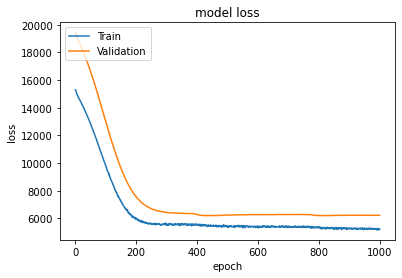

In [55]:
hist1 = Model1.fit(x_train, y_train, epochs=1000, batch_size=4096, verbose=1, validation_split=0.25)
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [56]:
def rul_mdl2(batch_size = None,in_feature = x_train.shape[2], out_f = 1, len_ts = x_train.shape[1]):
    inp = layers.Input(batch_shape= (batch_size, len_ts, x_train.shape[2]), name="Input")
    l1 = layers.LSTM(units = int(x_train.shape[2]/2),return_sequences = True, name = 'Bi-LSTM1')(inp)
    l1d = layers.Dropout(0.3, name = 'DropOut-1')(l1)
    l1c = layers.Conv1D(filters = int(x_train.shape[2]/2),kernel_size = 32, name = 'Convolution-1')(l1d)
    l1mp = layers.MaxPool1D(pool_size=2, name = 'MaxPool-1')(l1c)
    l2 = layers.LSTM(units = int(x_train.shape[2]/4),return_sequences = True, name = 'Bi-LSTM2')(l1mp)
    l2d = layers.Dropout(0.3, name = 'DropOut-2')(l2)
    l2c = layers.Conv1D(filters = int(x_train.shape[2]/4),kernel_size = 32, name = 'Convolution-2')(l2d)
    l2mp = layers.MaxPooling1D(pool_size=2, name = 'MaxPool-2')(l2c)
    l3 = layers.LSTM(units = int(x_train.shape[2]/10), return_sequences = False)(l2mp)
    l4 = layers.Dense(units = int(x_train.shape[2]/10), activation = 'relu', name = 'Fully-Connected')(l3)
    out = layers.Dense(units = out_f, activation = 'linear', name = 'Output')(l4)
    M = models.Model(inputs = inp, outputs =  out)
    M.compile(loss='mean_squared_error', optimizer='adam')
    return M
Model2 = rul_mdl2()
Model2.summary()
    

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 93)]         0         
_________________________________________________________________
Bi-LSTM1 (LSTM)              (None, 128, 46)           25760     
_________________________________________________________________
DropOut-1 (Dropout)          (None, 128, 46)           0         
_________________________________________________________________
Convolution-1 (Conv1D)       (None, 97, 46)            67758     
_________________________________________________________________
MaxPool-1 (MaxPooling1D)     (None, 48, 46)            0         
_________________________________________________________________
Bi-LSTM2 (LSTM)              (None, 48, 23)            6440      
_________________________________________________________________
DropOut-2 (Dropout)          (None, 48, 23)            0   

Epoch 1/1000
4/4 [==============================] - 84s 15s/step - loss: 15289.3389 - val_loss: 19418.0078
Epoch 2/1000
4/4 [==============================] - 69s 18s/step - loss: 15178.8086 - val_loss: 19287.7402
Epoch 3/1000
4/4 [==============================] - 67s 9s/step - loss: 15078.4727 - val_loss: 19195.4609
Epoch 4/1000
4/4 [==============================] - 42s 7s/step - loss: 14991.7646 - val_loss: 19069.1074
Epoch 5/1000
4/4 [==============================] - 21s 5s/step - loss: 14912.8076 - val_loss: 19017.8672
Epoch 6/1000
4/4 [==============================] - 25s 6s/step - loss: 14863.5918 - val_loss: 18945.8730
Epoch 7/1000
4/4 [==============================] - 25s 5s/step - loss: 14801.4160 - val_loss: 18894.8105
Epoch 8/1000
4/4 [==============================] - 22s 5s/step - loss: 14764.4492 - val_loss: 18861.0195
Epoch 9/1000
4/4 [==============================] - 18s 5s/step - loss: 14733.2080 - val_loss: 18830.3652
Epoch 10/1000
4/4 [=========================

4/4 [==============================] - 20s 5s/step - loss: 13188.3281 - val_loss: 17082.3105
Epoch 78/1000
4/4 [==============================] - 21s 5s/step - loss: 13159.0898 - val_loss: 17049.0176
Epoch 79/1000
4/4 [==============================] - 21s 5s/step - loss: 13129.6641 - val_loss: 17015.5273
Epoch 80/1000
4/4 [==============================] - 19s 5s/step - loss: 13100.1016 - val_loss: 16981.8184
Epoch 81/1000
4/4 [==============================] - 21s 5s/step - loss: 13070.3506 - val_loss: 16947.9043
Epoch 82/1000
4/4 [==============================] - 21s 5s/step - loss: 13040.4346 - val_loss: 16913.7969
Epoch 83/1000
4/4 [==============================] - 19s 5s/step - loss: 13010.2998 - val_loss: 16879.5137
Epoch 84/1000
4/4 [==============================] - 26s 7s/step - loss: 12980.0684 - val_loss: 16845.0215
Epoch 85/1000
4/4 [==============================] - 23s 5s/step - loss: 12949.6055 - val_loss: 16810.3477
Epoch 86/1000
4/4 [==============================] 

4/4 [==============================] - 24s 6s/step - loss: 10603.1240 - val_loss: 14113.7139
Epoch 154/1000
4/4 [==============================] - 22s 5s/step - loss: 10566.3027 - val_loss: 14070.9619
Epoch 155/1000
4/4 [==============================] - 19s 5s/step - loss: 10529.4209 - val_loss: 14028.1572
Epoch 156/1000
4/4 [==============================] - 21s 5s/step - loss: 10492.5859 - val_loss: 13985.2891
Epoch 157/1000
4/4 [==============================] - 19s 5s/step - loss: 10455.7109 - val_loss: 13942.3750
Epoch 158/1000
4/4 [==============================] - 23s 5s/step - loss: 10418.7383 - val_loss: 13899.4570
Epoch 159/1000
4/4 [==============================] - 20s 5s/step - loss: 10381.9258 - val_loss: 13856.4590
Epoch 160/1000
4/4 [==============================] - 26s 6s/step - loss: 10344.7656 - val_loss: 13813.5342
Epoch 161/1000
4/4 [==============================] - 19s 5s/step - loss: 10307.8936 - val_loss: 13770.5342
Epoch 162/1000
4/4 [=======================

4/4 [==============================] - 20s 5s/step - loss: 7904.3276 - val_loss: 10924.9688
Epoch 230/1000
4/4 [==============================] - 35s 8s/step - loss: 7872.1694 - val_loss: 10885.9180
Epoch 231/1000
4/4 [==============================] - 23s 5s/step - loss: 7839.9824 - val_loss: 10847.0312
Epoch 232/1000
4/4 [==============================] - 19s 5s/step - loss: 7807.9463 - val_loss: 10808.2773
Epoch 233/1000
4/4 [==============================] - 18s 5s/step - loss: 7776.0225 - val_loss: 10769.6562
Epoch 234/1000
4/4 [==============================] - 18s 5s/step - loss: 7744.5420 - val_loss: 10731.0195
Epoch 235/1000
4/4 [==============================] - 27s 7s/step - loss: 7712.7935 - val_loss: 10692.6133
Epoch 236/1000
4/4 [==============================] - 24s 6s/step - loss: 7681.2974 - val_loss: 10654.3682
Epoch 237/1000
4/4 [==============================] - 19s 5s/step - loss: 7650.0410 - val_loss: 10616.2139
Epoch 238/1000
4/4 [==============================] 

4/4 [==============================] - 21s 6s/step - loss: 5869.1787 - val_loss: 8373.7939
Epoch 307/1000
4/4 [==============================] - 30s 7s/step - loss: 5849.3276 - val_loss: 8347.5176
Epoch 308/1000
4/4 [==============================] - 20s 5s/step - loss: 5829.6997 - val_loss: 8321.4268
Epoch 309/1000
4/4 [==============================] - 19s 5s/step - loss: 5810.0640 - val_loss: 8295.6006
Epoch 310/1000
4/4 [==============================] - 23s 5s/step - loss: 5790.7358 - val_loss: 8269.9600
Epoch 311/1000
4/4 [==============================] - 19s 5s/step - loss: 5771.6309 - val_loss: 8244.4941
Epoch 312/1000
4/4 [==============================] - 21s 5s/step - loss: 5752.6396 - val_loss: 8219.2256
Epoch 313/1000
4/4 [==============================] - 23s 6s/step - loss: 5733.8652 - val_loss: 8194.1143
Epoch 314/1000
4/4 [==============================] - 19s 5s/step - loss: 5715.3330 - val_loss: 8169.1484
Epoch 315/1000
4/4 [==============================] - 22s 6s/

4/4 [==============================] - 20s 5s/step - loss: 4816.4590 - val_loss: 6882.4067
Epoch 384/1000
4/4 [==============================] - 23s 6s/step - loss: 4808.3687 - val_loss: 6869.5059
Epoch 385/1000
4/4 [==============================] - 20s 5s/step - loss: 4800.3354 - val_loss: 6856.7817
Epoch 386/1000
4/4 [==============================] - 23s 5s/step - loss: 4792.6934 - val_loss: 6844.0962
Epoch 387/1000
4/4 [==============================] - 21s 5s/step - loss: 4784.8794 - val_loss: 6831.6299
Epoch 388/1000
4/4 [==============================] - 21s 5s/step - loss: 4777.3032 - val_loss: 6819.2837
Epoch 389/1000
4/4 [==============================] - 20s 5s/step - loss: 4769.7480 - val_loss: 6807.1313
Epoch 390/1000
4/4 [==============================] - 22s 5s/step - loss: 4762.5190 - val_loss: 6795.0386
Epoch 391/1000
4/4 [==============================] - 19s 5s/step - loss: 4755.0938 - val_loss: 6783.1885
Epoch 392/1000
4/4 [==============================] - 19s 5s/

4/4 [==============================] - 21s 5s/step - loss: 4464.2852 - val_loss: 6236.5034
Epoch 461/1000
4/4 [==============================] - 24s 5s/step - loss: 4462.3193 - val_loss: 6231.7622
Epoch 462/1000
4/4 [==============================] - 22s 5s/step - loss: 4460.4297 - val_loss: 6227.0601
Epoch 463/1000
4/4 [==============================] - 26s 7s/step - loss: 4458.5410 - val_loss: 6222.4468
Epoch 464/1000
4/4 [==============================] - 19s 5s/step - loss: 4456.6807 - val_loss: 6217.9253
Epoch 465/1000
4/4 [==============================] - 21s 5s/step - loss: 4454.8711 - val_loss: 6213.4785
Epoch 466/1000
4/4 [==============================] - 25s 6s/step - loss: 4453.1328 - val_loss: 6209.0708
Epoch 467/1000
4/4 [==============================] - 19s 5s/step - loss: 4451.3857 - val_loss: 6204.7632
Epoch 468/1000
4/4 [==============================] - 19s 5s/step - loss: 4449.6646 - val_loss: 6200.5386
Epoch 469/1000
4/4 [==============================] - 22s 6s/

4/4 [==============================] - 22s 5s/step - loss: 4393.7900 - val_loss: 6018.2456
Epoch 538/1000
4/4 [==============================] - 18s 4s/step - loss: 4393.4966 - val_loss: 6016.8354
Epoch 539/1000
4/4 [==============================] - 19s 5s/step - loss: 4393.2383 - val_loss: 6015.4175
Epoch 540/1000
4/4 [==============================] - 27s 7s/step - loss: 4392.9727 - val_loss: 6014.0244
Epoch 541/1000
4/4 [==============================] - 19s 5s/step - loss: 4392.7407 - val_loss: 6012.6108
Epoch 542/1000
4/4 [==============================] - 18s 5s/step - loss: 4392.4873 - val_loss: 6011.2358
Epoch 543/1000
4/4 [==============================] - 22s 5s/step - loss: 4392.2490 - val_loss: 6009.8853
Epoch 544/1000
4/4 [==============================] - 20s 5s/step - loss: 4392.0225 - val_loss: 6008.5542
Epoch 545/1000
4/4 [==============================] - 23s 6s/step - loss: 4391.7788 - val_loss: 6007.2993
Epoch 546/1000
4/4 [==============================] - 25s 7s/

4/4 [==============================] - 22s 6s/step - loss: 4385.6333 - val_loss: 5955.4238
Epoch 615/1000
4/4 [==============================] - 20s 5s/step - loss: 4385.6094 - val_loss: 5955.0186
Epoch 616/1000
4/4 [==============================] - 22s 5s/step - loss: 4385.5825 - val_loss: 5954.6626
Epoch 617/1000
4/4 [==============================] - 21s 5s/step - loss: 4385.5649 - val_loss: 5954.2764
Epoch 618/1000
4/4 [==============================] - 22s 5s/step - loss: 4385.5435 - val_loss: 5953.9072
Epoch 619/1000
4/4 [==============================] - 20s 5s/step - loss: 4385.5298 - val_loss: 5953.5200
Epoch 620/1000
4/4 [==============================] - 18s 5s/step - loss: 4385.5020 - val_loss: 5953.2163
Epoch 621/1000
4/4 [==============================] - 28s 8s/step - loss: 4385.4873 - val_loss: 5952.8765
Epoch 622/1000
4/4 [==============================] - 28s 7s/step - loss: 4385.4771 - val_loss: 5952.4873
Epoch 623/1000
4/4 [==============================] - 18s 5s/

4/4 [==============================] - 18s 5s/step - loss: 4385.0767 - val_loss: 5939.6104
Epoch 692/1000
4/4 [==============================] - 18s 5s/step - loss: 4385.0752 - val_loss: 5939.5459
Epoch 693/1000
4/4 [==============================] - 22s 6s/step - loss: 4385.0752 - val_loss: 5939.4458
Epoch 694/1000
4/4 [==============================] - 21s 5s/step - loss: 4385.0737 - val_loss: 5939.3701
Epoch 695/1000
4/4 [==============================] - 18s 5s/step - loss: 4385.0732 - val_loss: 5939.3330
Epoch 696/1000
4/4 [==============================] - 20s 5s/step - loss: 4385.0732 - val_loss: 5939.2500
Epoch 697/1000
4/4 [==============================] - 21s 5s/step - loss: 4385.0728 - val_loss: 5939.1855
Epoch 698/1000
4/4 [==============================] - 18s 5s/step - loss: 4385.0718 - val_loss: 5939.0962
Epoch 699/1000
4/4 [==============================] - 18s 5s/step - loss: 4385.0708 - val_loss: 5939.0425
Epoch 700/1000
4/4 [==============================] - 24s 5s/

4/4 [==============================] - 18s 5s/step - loss: 4385.0562 - val_loss: 5936.5083
Epoch 769/1000
4/4 [==============================] - 21s 5s/step - loss: 4385.0562 - val_loss: 5936.4746
Epoch 770/1000
4/4 [==============================] - 18s 4s/step - loss: 4385.0571 - val_loss: 5936.4185
Epoch 771/1000
4/4 [==============================] - 18s 5s/step - loss: 4385.0581 - val_loss: 5936.3813
Epoch 772/1000
4/4 [==============================] - 20s 5s/step - loss: 4385.0562 - val_loss: 5936.3940
Epoch 773/1000
4/4 [==============================] - 18s 4s/step - loss: 4385.0566 - val_loss: 5936.4019
Epoch 774/1000
4/4 [==============================] - 23s 6s/step - loss: 4385.0571 - val_loss: 5936.4399
Epoch 775/1000
4/4 [==============================] - 18s 5s/step - loss: 4385.0562 - val_loss: 5936.4404
Epoch 776/1000
4/4 [==============================] - 18s 4s/step - loss: 4385.0562 - val_loss: 5936.4263
Epoch 777/1000
4/4 [==============================] - 23s 6s/

4/4 [==============================] - 25s 7s/step - loss: 4385.0566 - val_loss: 5936.0840
Epoch 846/1000
4/4 [==============================] - 23s 6s/step - loss: 4385.0571 - val_loss: 5936.0815
Epoch 847/1000
4/4 [==============================] - 19s 4s/step - loss: 4385.0566 - val_loss: 5936.0942
Epoch 848/1000
4/4 [==============================] - 21s 5s/step - loss: 4385.0586 - val_loss: 5936.1743
Epoch 849/1000
4/4 [==============================] - 21s 5s/step - loss: 4385.0581 - val_loss: 5936.1099
Epoch 850/1000
4/4 [==============================] - 18s 4s/step - loss: 4385.0562 - val_loss: 5936.1489
Epoch 851/1000
4/4 [==============================] - 19s 5s/step - loss: 4385.0571 - val_loss: 5936.1523
Epoch 852/1000
4/4 [==============================] - 19s 5s/step - loss: 4385.0557 - val_loss: 5936.1919
Epoch 853/1000
4/4 [==============================] - 19s 5s/step - loss: 4385.0566 - val_loss: 5936.2197
Epoch 854/1000
4/4 [==============================] - 19s 5s/

4/4 [==============================] - 20s 5s/step - loss: 4385.0562 - val_loss: 5936.1499
Epoch 923/1000
4/4 [==============================] - 23s 5s/step - loss: 4385.0566 - val_loss: 5936.1445
Epoch 924/1000
4/4 [==============================] - 18s 5s/step - loss: 4385.0562 - val_loss: 5936.1465
Epoch 925/1000
4/4 [==============================] - 21s 5s/step - loss: 4385.0566 - val_loss: 5936.1895
Epoch 926/1000
4/4 [==============================] - 18s 4s/step - loss: 4385.0566 - val_loss: 5936.1826
Epoch 927/1000
4/4 [==============================] - 17s 4s/step - loss: 4385.0562 - val_loss: 5936.2305
Epoch 928/1000
4/4 [==============================] - 22s 6s/step - loss: 4385.0576 - val_loss: 5936.2959
Epoch 929/1000
4/4 [==============================] - 24s 6s/step - loss: 4385.0576 - val_loss: 5936.2690
Epoch 930/1000
4/4 [==============================] - 18s 5s/step - loss: 4385.0566 - val_loss: 5936.3071
Epoch 931/1000
4/4 [==============================] - 19s 5s/

4/4 [==============================] - 20s 5s/step - loss: 4385.0581 - val_loss: 5936.5049
Epoch 1000/1000
4/4 [==============================] - 18s 5s/step - loss: 4385.0571 - val_loss: 5936.5273


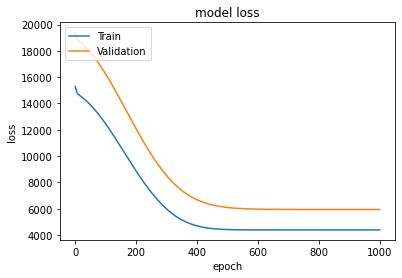

In [57]:
hist2 = Model2.fit(x_train, y_train, epochs=1000, batch_size=4096, verbose=1, validation_split=0.25)
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [58]:
rul_pred1,rul_pred2 = Model1.predict(x_test, verbose =1),Model2.predict(x_test, verbose =1)

406/406 [==============================] - 13s 21ms/step


In [59]:
y_test = y_test.reshape(-1,1)
res = np.concatenate([y_test, rul_pred1,rul_pred2], axis = 1)

In [60]:
print(rul_pred1.shape)
print(y_test.shape)
print(res.shape)

(12969, 1)
(12969, 1)
(12969, 3)


In [61]:
res_df = pd.DataFrame(res, columns=['Actual_RUL', 'RUL_pred1', 'RUL_pred2'])
res_df.to_csv('Result_naive_DL_RUL.csv')